## AIM:
Predict tweets which are hate tweets

Importing the necessary libraries:

In [125]:
import numpy as np
import pandas as pd
import seaborn as sns
import re
import matplotlib.pyplot as plt
from matplotlib import style
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
stop_words = set(stopwords.words('english'))
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

### Importing the dataset:
Dataset contains nearly 32K tweets which are labeled based on having racist or sexist content. We are going to analyse this dataset and tweets, and by the end, create a classification model to classify tweets.
Each row in the dataset has 3 columns:  
>    `id`: Assigned ID to this tweet by Analytics Vidhya.  
    `label`: Tweet label, 1 if tweet has hatred content and 0 otherwise.  
    `tweet`: Tweet text.  

Dataset source: Analytics Vidhya

In [1]:
dataset = r"C:\Users\super\Software\Mega\Academics\5th sem labs\DS Lab\Datasets\twitter_train.csv"

In [126]:
df = pd.read_csv(dataset)

In [127]:
df.head()

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation


In [128]:
df.shape

(31962, 3)

#### Dropping duplicates (if any)

In [ ]:
df = df.drop_duplicates('tweet')
df.head()

In [99]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29530 entries, 0 to 31961
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      29530 non-null  int64 
 1   label   29530 non-null  int64 
 2   tweet   29530 non-null  object
dtypes: int64(2), object(1)
memory usage: 922.8+ KB


#### Lets see how many tweets are hatred and non-hatred in the dataset:

In [129]:
print("Hatred labeled: {}\nNon-hatred labeled: {}".format(
    (df.label == 1).sum(),
    (df.label == 0).sum()
))

Hatred labeled: 2242
Non-hatred labeled: 29720


Plotting a bar plot for the same:

<AxesSubplot:xlabel='label', ylabel='count'>

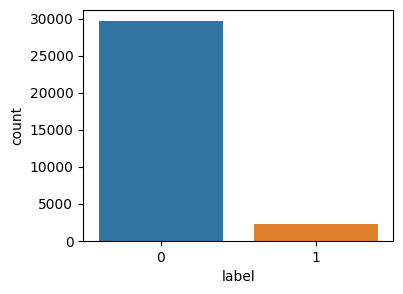

In [174]:
fig = plt.figure(figsize=(4,3))
sns.countplot(x='label', data=df)

#### Removing anything but the words
Now we'll remove anything but the words (punctuations, numbers, etc). Note that this time we'll replace them with a blank space since it might be a _ or - or a punctuation with no space from the next word and we don't want the words to join together.

In [101]:
df.tweet = df.tweet.str.replace('[^a-zA-Z]', ' ')

C:\Users\super\AppData\Local\Temp\ipykernel_13996\3655582587.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  df.tweet = df.tweet.str.replace('[^a-zA-Z]', ' ')


In [102]:
lemmatizer = WordNetLemmatizer()
def lemmatizing(data):
    tweet = [lemmatizer.lemmatize(word) for word in data]
    return data

In [116]:
def data_processing(tweet):
    tweet = str(tweet)
    tweet = tweet.lower()
    tweet = re.sub(r"https\S+|www\S+http\S+", "", tweet, flags = re.MULTILINE)
    tweet = re.sub(r'\@w+|\#','', tweet)
    tweet = re.sub(r'[^\w\s]', '', tweet)
    tweet = re.sub(r'ð', '', tweet)
    tweet_tokens = word_tokenize(tweet)
    filtered_tweets = [w for w in tweet_tokens if not w in stop_words]
    return " ".join(filtered_tweets)

In [117]:
df['tweet'] = df['tweet'].apply(data_processing)

In [118]:
df['tweet'] = df['tweet'].apply(lambda x: lemmatizing(x))

In [123]:
df[['tweet']]

,tweet
0,none
1,none
2,none
3,none
4,none
...,...
31956,none
31957,none
31958,none
31959,none


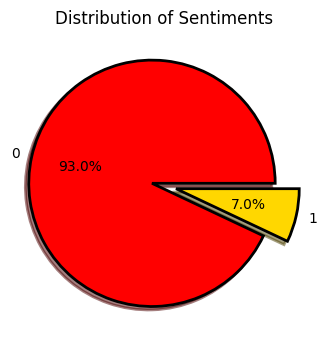

In [166]:
fig = plt.figure(figsize=(4,4))
colors = ("red", "gold")
wp = {'linewidth':2, 'edgecolor':'black'}
tags = df['label'].value_counts()
explode = (0.1,0.1)
tags.plot(kind='pie', autopct= '%1.1f%%', shadow=True, colors=colors, explode=explode, wedgeprops=wp, label='')
plt.title('Distribution of Sentiments')
plt.show()

In [51]:
hate_tweets = df[df.label == 1]
hate_tweets.head()

,id,label,tweet
13,14,1,user cnn calls michigan middle school buil...
14,15,1,no comment in australia opkillingbay se...
17,18,1,retweet if you agree
23,24,1,user user lumpy says i am a prove it lumpy
34,35,1,it s unbelievable that in the st century we ...


#### Frequent words
Now let's see what words and hashtags are the most frequenst in hate tweets and in total.


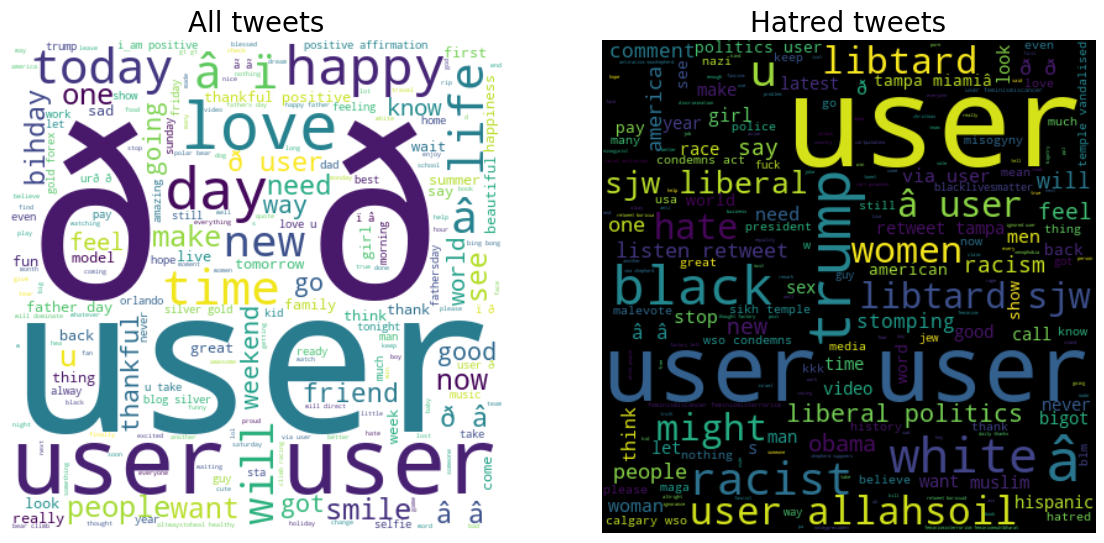

In [168]:
data = df
from wordcloud import WordCloud, STOPWORDS
stopwords = STOPWORDS.add('amp')

all_words = ' '.join(data.tweet.values)
hatred_words = ' '.join(data[data.label == 1].tweet.values)

plt.figure(figsize=(14, 7))

cloud1 = WordCloud(width=400, height=400, background_color='white', stopwords=stopwords).generate(all_words)
plt.subplot(121)
plt.imshow(cloud1, interpolation="bilinear")
plt.axis("off")
plt.title('All tweets', size=20)

cloud2 = WordCloud(width=400, height=400, background_color='black', stopwords=stopwords).generate(hatred_words)
plt.subplot(122)
plt.imshow(cloud2, interpolation="bilinear")
plt.axis("off")
plt.title('Hatred tweets', size=20)
plt.show()

### Model Building and Training:

In [142]:
vect = TfidfVectorizer(ngram_range=(1,2)).fit(df['tweet'])

#### Splitting the dataset for training and testing:

In [143]:
X = df['tweet']
Y = df['label']
X = vect.transform(X)
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=0)
print("Size of x_train:", (x_train.shape))                                                    
print("Size of y_train:", (y_train.shape))                                                    
print("Size of x_test:", (x_test.shape))                                                    
print("Size of y_test:", (y_test.shape))                                                    

Size of x_train: (25569, 228267)
Size of y_train: (25569,)
Size of x_test: (6393, 228267)
Size of y_test: (6393,)


We will use Logistic Regression model for this dataset

In [145]:
logreg = LogisticRegression()
logreg.fit(x_train, y_train)

LogisticRegression()

#### Testing the model:

In [146]:
logreg_predict = logreg.predict(x_test)

#### Accuracy of the model predictions:

In [147]:
logreg_acc = accuracy_score(logreg_predict, y_test)
print('Test accuracy: {:.2f}%'.format(logreg_acc*100))

Test accuracy: 94.57%


In [148]:
from sklearn.metrics import plot_confusion_matrix

#### Classification Report:

In [153]:
print(classification_report(y_test, logreg_predict))

              precision    recall  f1-score   support

           0       0.95      1.00      0.97      5985
           1       0.97      0.15      0.27       408

    accuracy                           0.95      6393
   macro avg       0.96      0.58      0.62      6393
weighted avg       0.95      0.95      0.93      6393



#### Confusion Matrix:

<AxesSubplot:xlabel='Predicted Label', ylabel='True Label'>

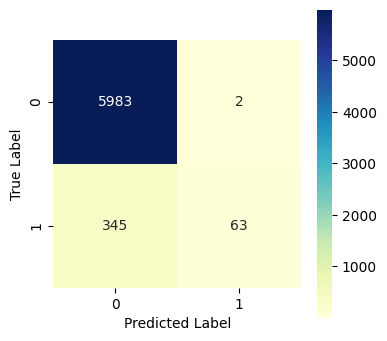

In [172]:
from sklearn import metrics
matrix_confusion = confusion_matrix(y_test, logreg_predict)
graph = sns.heatmap(matrix_confusion, square=True, annot=True, cmap='YlGnBu', fmt='d')
graph.set_xlabel('Predicted Label')
graph.set_ylabel('True Label')
graph.figure.set_size_inches(4,4)
graph

### Conclusion:
Required task have been performed on the dataset and the dataset was used to train Logistic Regression Alogrithm.
Accuracy of `94.57%` was achieved.  
Confusion Matrix for the classification results was also created. 